# Homogenization method - order 1 laminate

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

## 1) Geometry

In [2]:
from Geometry import transformer

mesh = transformer(NCoils = 2, hmax=0.005)

Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 2) Homogenized reluctivity tensor

We assume we have an order 1 laminate.

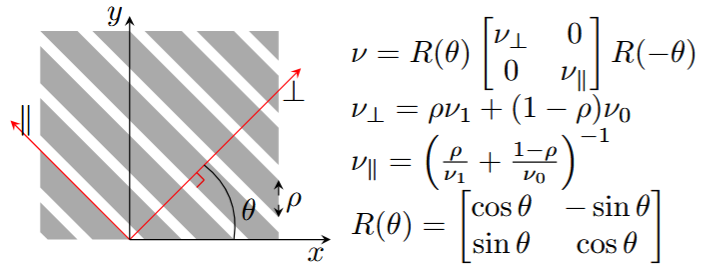

In [3]:
nu0 = 1/(4e-7 * pi)
nuIron = nu0/1000

def R(th):
    return CF( ( (cos(th), -sin(th)), (sin(th), cos(th)) ), dims = (2,2) )

def tR(th):
    return R(-th)

def diag(c11, c22):
    return CF( ((c11, 0), (0, c22) ), dims = (2,2))

def nuSerial(rh): 
    """ arithmetic mean """
    return (1-rh) * nu0 + rh * nuIron

def dnuSerial(rh): 
    return nuIron - nu0

def nuParallel(rh) :
    """ harmonic mean """
    return 1/( (1-rh) / nu0 + rh/nuIron )

def dnuParallel(rh) :
    return nu0 * nuIron * (nuIron - nu0) / (nuIron * (1-rho) + rho * nu0)**2

def nuTensor(rh):
    return diag(nuSerial(rh), nuParallel(rh))
    
def nu(rh,th):
    """ Homogenized tensor """
    return R(th) * nuTensor(rh) * tR(th)

def dnu(rh, th):
    dnudrho = R(th) * diag(dnuSerial(rh), dnuParallel(rh)) * tR(th)
    dnudth = R(th + pi/2) * nuTensor(rh) * tR(th) + R(th) * nuTensor(rh) * tR(th + pi/2)
    return dnudrho.Compile(), dnudth.Compile()
    
def DrawMat(rh, th, scene = None):
    """ plot along the parallel direction """
    if scene is None :
        scene = Draw(rh*CF((cos(th+pi/2),sin(th+pi/2))), mesh, vectors = { "grid_size":20}, 
                     settings = {"Objects" : { "Wireframe" : False } } , min=0, max=1)
        return scene
    else:
        scene.Redraw(rh*CF((cos(th+pi/2),sin(th+pi/2))), mesh, vectors = { "grid_size":20},
                     settings = {"Objects" : { "Wireframe" : False } }, min=0, max=1)

rho, theta = GridFunction(L2(mesh)), GridFunction(L2(mesh))
rho.Set(CF(0.5))
theta.Set(-pi/2)
DrawMat(rho,theta)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 3) Magnetostatic problem

In [4]:
from Solver import solveMag

a0, Kinv = solveMag(nu(rho,theta), mesh)

Draw(a0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 4) Objective function & adjoint problem
### a) Objective function

In [5]:
def avgSecondaryFlux(state):
    return Integrate ( state, mesh.Materials("Sp") ) - Integrate ( state, mesh.Materials("Sm") ) 

normalization = 1e-3    # so that the objective function is comparable to the constraint
# we want to maximize the secondary flux = minimize its opposite
def objectiveFunction(state):
    return - avgSecondaryFlux(state) / normalization

print(f" {objectiveFunction(a0) = :.5e} Wb/m")

 objectiveFunction(a0) = -3.38561e-05 Wb/m


### b) Adjoint problem

In [6]:
def objectiveFunctionDD(a, aStar):
    """ Directional derivative of the objective function in the direction aStar """
    return aStar/ normalization*dx("Sm")  - aStar/ normalization*dx("Sp")

from Solver import solveAdjoint

p0 = solveAdjoint(Kinv, a0, objectiveFunctionDD)

Draw(p0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 5) Gradient of objective function w.r.t $\rho$

In [7]:
from Solver import Curl

def dobjectiveFunction_drho(rho, theta, state, adjoint):
    dnudrho, _ = dnu(rho, theta)
    return - Curl(adjoint) * (dnudrho * Curl(state))

def dobjectiveFunction_dth(rho, theta, state, adjoint):
    _, dnudth = dnu(rho, theta)
    return - Curl(adjoint) * (dnudth * Curl(state))

Draw(dobjectiveFunction_drho(rho, theta, a0, p0), mesh, settings = {"Objects" : { "Wireframe" : False } })
Draw(dobjectiveFunction_dth(rho, theta, a0, p0), mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 6) Volume

In [8]:
V0 = Integrate(CF((1)), mesh) # volume of Omega

def volume(rho):
    return Integrate(rho, mesh) / V0

def dvolume_drho(rho):
    """ Scalar field representing the linear form obtained by the directional derivative of the volume 
    The directionnal derivative in the gamma direction reads < dvolume_drho, gamma > """
    return CF((1)) / V0

## 7) Optimization

We use an augmented Lagrange algorithm. We want to find the saddle point of the augmented Lagrangian

$$ \mathcal L(\rho,\lambda) = f(\rho) + \lambda g(\rho) + \frac{\beta}{2} (g(\rho))^2$$

with $f$ the objective function, $\lambda$ a Lagrange multiplier and $g$ an equality constraint. So, $\mathcal L$ should be minimized w.r.t $\rho$ and maximized w.r.t $\lambda$ :

$$ (\rho^*, \lambda^*) = \arg \max_\lambda \min_{\rho} L(\rho,\lambda)  $$

The algorithm is the following loop :
- Inner minimization of $\mathcal L(\rho,\lambda)$ w.r.t $\rho$
- Update of $\lambda$ such that $\lambda \gets \lambda + \beta g(\rho)$ so that $\lambda$ increases

### a) Inner minimization

We use a projected gradient descent with simple step control.

In [9]:
from copy import copy

mask = GridFunction(L2(mesh))
mask.Set(mesh.MaterialCF({"Omega_c" : 1}))
maskOmega_c = mask.vec.FV().NumPy()[:]

def innerMinimization(rho, theta, lam, 
                      step = 0.1, beta = 1e-3,
                      n_max = 50, step_min = 1e-4, 
                      f = objectiveFunction,                                # df_du(u)
                      g = lambda rho : (volume(rho) - 0.1),                 # g(rho)
                      df_du = objectiveFunctionDD,                          # df_du(u, uStar)
                      dg_drho = dvolume_drho,                               # dg_drho(rho)
                      df_drho = dobjectiveFunction_drho,                    # df_drho(rho, th, u, p)
                      df_dth = dobjectiveFunction_dth,                      # df_dth(rho, th, u, p)
                      maskOmega_c = maskOmega_c,                            # mask of the optimization domain
                      scene = None):
    n = 0
    mesh = rho.space.mesh
    Lagr = lambda rho, u : f(u) + lam * g(rho) + beta / 2 * (g(rho))**2
    dLagr_drho = lambda rho, th, u, p : df_drho(rho, th, u, p) + lam * dg_drho(rho) + beta * g(rho)
    dLagr_dth = lambda rho, th, u, p : df_dth(rho, th, u, p) 
    u = solveMag(nu(rho, theta), mesh)[0]
    L_history = [Lagr( rho, u)]
    obj_history = [f(u)]
    g_history = [g(rho)]
    rho_history = [copy(rho)]
    theta_history = [copy(theta)]
    while ( n < n_max and step > step_min):

        n += 1
        if scene is not None : DrawMat(rho,theta, scene)

        step = min(step, 0.1)
    
        # 1) Magnetic state computation
        u, Kinv = solveMag(nu(rho, theta), mesh)
        
        # 2) Adjoint computation
        p = solveAdjoint(Kinv, u, df_du)
        
        # 3) Gradient computation
        grad_rho = dLagr_drho(rho, theta, u, p)
        grad_th =  dLagr_dth(rho, theta, u, p)

        # 4) Gradient preconditioning
        descent_rho = - atan(1e3 * grad_rho) * 2/pi
        descent_th  = - atan(1e3 * grad_th)  * 2/pi

        # 4) Update
        rho_test = GridFunction(rho.space)
        theta_test = GridFunction(theta.space)
        rho_test.Set(rho + step * descent_rho)
        theta_test.Set(theta + step * pi * descent_th)
        
        # 5) Projection
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
        rho_test.vec[:].FV().NumPy()[maskOmega_c==0] = 0
        theta_test.vec[:].FV().NumPy()[:] = ((2*(theta_test.vec[:].FV().NumPy()[:] + pi/2)) % (2*pi))/2 - pi/2
        
        # 6) Step control
        u_test, _ = solveMag(nu(rho_test, theta_test), mesh)
        L_history.append(Lagr(rho_test, u_test))
        g_history.append(g(rho_test))
        obj_history.append(f(u_test))
        
        print(f'it n°{n} | f = {L_history[-1] :.6e} | g = {g_history[-1]  :.3e} | {step = : .3e}                   ', end = '\r')
        
        if L_history[-1] >= L_history[-2]:   # failure
            step *= 0.5
            L_history.pop(); g_history.pop() ; obj_history.pop()
        else :                               # succes
            step *= 1.2
            rho = rho_test
            theta = theta_test
            rho_history.append(copy(rho))
            theta_history.append(copy(theta))
    return rho_history, theta_history, L_history, obj_history, g_history, step, n 

### b) Optimization parameters

In [10]:
## Initialization

theta0 = -pi/2
mass_target = 0.1   # Target volume
rho0 = mass_target         # Initial value of rho (homogeneous)
rho = GridFunction(L2(mesh))
rho.Set(mesh.MaterialCF({ "Omega_c" : rho0}, default=0))
theta = GridFunction(L2(mesh))
theta.Set(mesh.MaterialCF({ "Omega_c" : theta0}, default=0))

beta = 2          # Penalization coefficient
lam = 0              # Initial value of Lagrange multiplier

step = 1e-2          # Initial step
step_min = 1e-6     # Minimal step 
N_outer_max = 100     # Maximal number of outer iteration (maximization)
N_inner_max = 5     # Maximal number of inner iteration (minimization)

N_outer = 0
N_endInner = [0]
N_iter_tot = 0
Lagr_OuterList, g_OuterList, f_OuterList = [], [], []
lamList = [lam]
rho_OuterList, theta_OuterList = [copy(rho)], [copy(theta)]
stepList = [step]

### c) Optimization loop

In [11]:
scene = DrawMat(rho,theta)

g  = lambda rho : (volume(rho) - 0.1)

for N_outer in range(N_outer_max) :

    print(f"\n{N_outer = }")
    rho_history, theta_history, L_history, obj_history, g_history, step, N_inner = innerMinimization(rho, theta,lam,
                                                           step = step, 
                                                           beta = beta,
                                                           g = g,
                                                           n_max = N_inner_max, 
                                                           step_min = step_min, 
                                                           scene = scene)
    
    rho = rho_history[-1]
    theta = theta_history[-1]
    rho_OuterList.append(copy(rho))
    theta_OuterList.append(copy(theta))

    Lagr_OuterList.append(L_history[-1])
    g_OuterList.append(g_history[-1])
    f_OuterList.append(obj_history[-1])
    N_iter_tot += N_inner
    N_endInner.append(N_iter_tot)
    stepList.append(step)
    step *= 2
    
    # update Lagrange multiplier
    lam += beta * g(rho)
    lamList.append(lam)
    
    

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…


N_outer = 0
it n°5 | f = -1.583170e-05 | g = 1.490e-03 | step =  3.600e-03                    
N_outer = 1
it n°5 | f = -1.688951e-05 | g = 2.548e-03 | step =  5.400e-04                   
N_outer = 2
it n°5 | f = -2.069580e-05 | g = -1.375e-03 | step =  1.120e-03                   
N_outer = 3
it n°5 | f = -2.275872e-05 | g = -1.535e-04 | step =  2.322e-03                   
N_outer = 4
it n°5 | f = -2.469648e-05 | g = 7.836e-04 | step =  2.006e-03                   
N_outer = 5
it n°5 | f = -2.699281e-05 | g = -1.268e-03 | step =  1.733e-03                   
N_outer = 6
it n°5 | f = -3.203181e-05 | g = 1.756e-03 | step =  1.498e-03                   
N_outer = 7
it n°5 | f = -3.809265e-05 | g = 1.096e-04 | step =  3.105e-03                   
N_outer = 8
it n°5 | f = -4.855700e-05 | g = -2.675e-03 | step =  6.439e-03                   
N_outer = 9
it n°5 | f = -5.711093e-05 | g = 6.823e-03 | step =  2.318e-03                   
N_outer = 10
it n°5 | f = -7.245793e-05 | g = -4.773e-

## 8) Analysis of the results

### a) Quantities of interest

In [16]:
u, _ = solveMag(nu(rho, theta),mesh)
print(f"Results homogenization : flux = {avgSecondaryFlux(u) : .5e} | vol = {volume(rho)*100 : .3f} % | iterations = {N_iter_tot}")

Results homogenization : flux =  2.75320e-05 | vol =  9.993 % | iterations = 500


### b) Evolution of the objective function and constraint

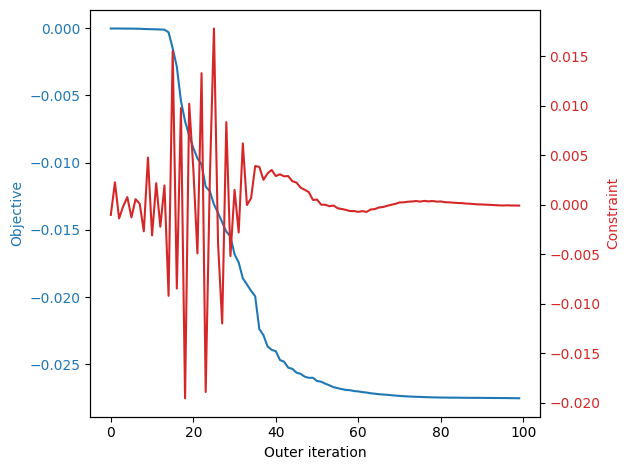

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(f_OuterList, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Outer iteration'); ax1.set_ylabel("Objective", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Constraint", color=color)
ax2.plot(g_OuterList, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

### b) Evolution of lambda and step

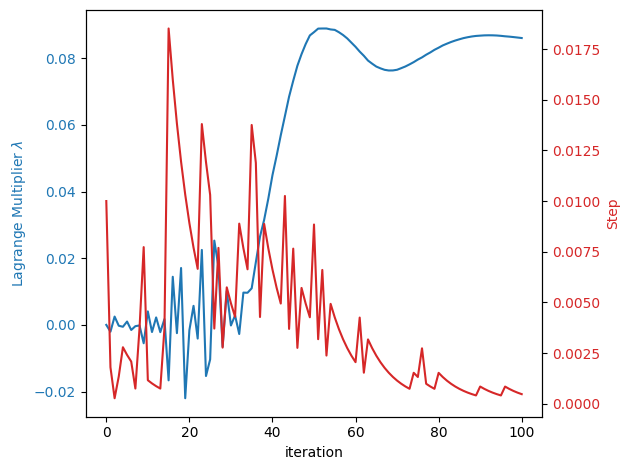

In [13]:
fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(lamList, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('iteration'); ax1.set_ylabel("Lagrange Multiplier $\lambda$", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Step", color=color)
ax2.plot(stepList, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()